In [2]:
#importing the libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import nltk
import custom_preprocessor as cp
import featurizer as f
import plot_learning_curve as plc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.vocab import  vocab
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, StepLR
from torch.utils.data import Dataset, DataLoader

import random
from datetime import datetime
import numpy as np
import pandas as pd
import joblib
from collections import Counter
from types import SimpleNamespace
import wandb

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score

In [3]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aswin1903. Use `wandb login --relogin` to force relogin


True

In [4]:
#Reading the data 
a=pd.read_excel("IntentData2.xlsx",sheet_name="Set 1")

In [5]:
b=pd.read_excel("IntentData2.xlsx",sheet_name="Set 2")

In [6]:
df=pd.concat([a,b],axis=0)

In [7]:
df.head()

,Original Comment,Positive,Negative (Other),Not Resolved,Hold,"Follow-up, Communication",Knowledge,Effort,Professionalism
0,Nothing has been resolved. We have been dealin...,NaN,NaN,Nothing has been resolved; dealing with the in...,NaN,NaN,NaN,NaN,NaN
1,Very professional and courteous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Thank you so much for the excellent customer s...,Thank you so much for the excellent customer s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Impressively fast service. Thank you for corre...,impressively fast service; thank you for corre...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Way too long waiting time! Insane to wait 1 h...,NaN,NaN,NaN,way too long waiting time; insane to wait 1 ho...,NaN,NaN,NaN,NaN


In [8]:
positive=df.Positive.unique()
cleaned_positive = positive[~pd.isnull(positive)]

In [9]:
negative=df['Negative (Other)'].unique()
cleaned_negative = negative[~pd.isnull(negative)]

In [10]:
not_res=df['Not Resolved'].unique()
cleaned_not_res = not_res[~pd.isnull(not_res)]

In [11]:
hold=df['Hold'].unique()
cleaned_hold = hold[~pd.isnull(hold)]

In [12]:
follow=df["Follow-up, Communication"].unique()
cleaned_follow=follow[~pd.isnull(follow)]

In [13]:
know=df["Knowledge"].unique()
cleaned_know=know[~pd.isnull(know)]

In [14]:
effort=df["Effort"].unique()
cleaned_effort=effort[~pd.isnull(effort)]

In [15]:
prof=df["Professionalism"].unique()
cleaned_prof=prof[~pd.isnull(prof)]

In [16]:
target_mapping = {
    'Positive': cleaned_positive, 'Negative (Other)':cleaned_negative, 'Not Resolved':cleaned_not_res,
       'Hold':cleaned_hold, 'Follow-up, Communication': cleaned_follow, 'Knowledge':cleaned_know, 'Effort':cleaned_effort,
       'Professionalism':cleaned_prof
}

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 700 entries, 0 to 499
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Original Comment          693 non-null    object
 1   Positive                  252 non-null    object
 2   Negative (Other)          82 non-null     object
 3   Not Resolved              109 non-null    object
 4   Hold                      8 non-null      object
 5   Follow-up, Communication  87 non-null     object
 6   Knowledge                 21 non-null     object
 7   Effort                    89 non-null     object
 8   Professionalism           30 non-null     object
dtypes: object(9)
memory usage: 54.7+ KB


In [18]:
target = []

# Iterate through rows

for index, row in df.iterrows():

    non_nan_columns = [column for column in df.columns[1:] if not pd.isna(row[column])]

    target.append(non_nan_columns)

df['Target'] = target

In [19]:
df1=df[["Original Comment","Target"]]

In [20]:
#Finding the number of missing targets
len(df1[df1['Target'].apply(len) == 0])

249

In [21]:
df2=df1[df1['Target'].apply(len) != 0]

In [22]:
#Number of records with the target columns:
len(df2)

451

In [23]:
df.columns

Index(['Original Comment', 'Positive', 'Negative (Other)', 'Not Resolved',
       'Hold', 'Follow-up, Communication', 'Knowledge', 'Effort',
       'Professionalism', 'Target'],
      dtype='object')

In [24]:
#Preprocessing the verbatim
preprocessor= cp.SpacyPreprocessor(model="en_core_web_sm",lammetize=False, remove_stop=False)
cleaned_text= preprocessor.fit_transform(df2['Original Comment'].values)

d:\Github repos\IntentModelling\custom_preprocessor.py:40: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  if (bool(BeautifulSoup(text, "html.parser").find())==True):


In [25]:
df2["cleaned_text"]=cleaned_text

C:\Users\aswin\AppData\Local\Temp\ipykernel_83048\1542965680.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["cleaned_text"]=cleaned_text


In [26]:
#Defining the Target Labels
target_labels=['Positive', 'Negative (Other)', 'Not Resolved',
       'Hold', 'Follow-up, Communication', 'Knowledge', 'Effort',
       'Professionalism']

# Initialize and fit the MultiLabelBinarizer
mlb = MultiLabelBinarizer()
encoded_targets = mlb.fit_transform(df2['Target'].apply(lambda x: [label for label in x if label in target_labels]))


In [27]:
#Separating the features and target
X=df2["cleaned_text"]
y=encoded_targets

In [28]:
#Creating a train test split
X_train,X_test1,y_train,y_test1=train_test_split(X,y,test_size=0.1,random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test1, y_test1, test_size= 0.5, random_state= 0)

In [29]:
#Creating a Custom Dataset 
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self,X,y):
        self.X=np.array(X)
        self.y=y
    
    def __len__(self):
        return(len(self.X))

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx=idx.tolist()
        text=self.X[idx]
        labels=self.y[idx]
        sample=(text,labels)
        return sample


In [30]:
train_set=CustomDataset(X_train,y_train)
valid_set=CustomDataset(X_valid,y_valid)
test_Set=CustomDataset(X_test,y_test)

In [31]:
#Vectorizing using tfidf vectorizer
vectorizer=TfidfVectorizer(stop_words="english",min_df=4,max_features=5000).fit(X_train)

In [32]:
X_train_vec=vectorizer.transform(X_train)
X_test_vec=vectorizer.transform(X_test)
X_valid_vec=vectorizer.transform(X_valid)

In [33]:
#Converting to Tensor
X_train_tensor=torch.tensor(X_train_vec.toarray()).float()
X_valid_tensor=torch.tensor(X_valid_vec.toarray()).float()
X_test_tensor=torch.tensor(X_test_vec.toarray()).float()

In [34]:
y_train_tensor=torch.tensor(np.array(y_train)).long()
y_valid_tensor=torch.tensor(np.array(y_valid)).long()
y_test_tensor=torch.tensor(np.array(y_test)).long()


In [35]:
#Creating a torch dataset
train_set =torch.utils.data.TensorDataset(X_train_tensor,y_train_tensor)
valid_set=torch.utils.data.TensorDataset(X_valid_tensor,y_valid_tensor)
test_set=torch.utils.data.TensorDataset(X_test_tensor,y_test_tensor)

In [36]:
#Creating Model

class Model(nn.Module):

    def __init__(self,input_dim,hidden_dim1,hidden_dim2,output_dim,non_linearity):
        self.input_dim=input_dim
        self.hidden_dim1=hidden_dim1
        self.hidden_dim2=hidden_dim2
        self.output_dim=output_dim
        self.non_linearity=non_linearity

        super().__init__()

        #hidden layer1
        self.hidden_layer1=nn.Linear(self.input_dim,self.hidden_dim1)
        #hidden layer2
        self.hidden_layer2=nn.Linear(self.hidden_dim1,self.hidden_dim2)
        #output layer
        self.output_layer=nn.Linear(self.hidden_dim2,self.output_dim)

    def forward(self,input):
        hout1=self.non_linearity(self.hidden_layer1(input))
        hout2=self.non_linearity(self.hidden_layer2(hout1))
        ypred=self.output_layer(hout2)

        return ypred

In [37]:
#Training model for each epoch 
def train(train_loader, model,optimizer,loss_function,log_batch,log_interval,grad_clipping,max_norm):

    #initializing variable as global 
    #Count will be updated for every epoch
    global example_ct_train
    global batch_ct_train

    #Training loop 
    #Initializing the train_loss at the the start of the epoch
    running_train_loss=0

    #Put model in training mode
    model.train()

    #Iterate on batches from the dataset using train_loader
    for input,targets in train_loader:
        # move inputs and outputs to GPUs
        input = input.to(device)
        targets = targets.to(device)

        #Forward pass
        output=model(input)
        loss=loss_function(output,targets.float())

        example_ct_train += len(targets)
        batch_ct_train+=1

        #set gradients to zero
        optimizer.zero_grad()

        #backward pass
        loss.backward()

        #Gradient clipping
        if grad_clipping:
            nn.utils.clip_grad_norm(model.parameters(),max_norm=max_norm,norm_type=2)

        #Update the parameters using their gradients
        optimizer.step()

        running_train_loss += loss.item()

        if log_batch:
            if((batch_ct_train+1) % log_interval)==0:
                wandb.log({f"Train Batch Loss: ":loss})
    
    #Calculate the mean train loss for the whole dataset for a particular epoch
    train_loss = running_train_loss/len(train_loader)

    return train_loss



In [38]:
def valid(loader,model,optimizer,loss_function,log_batch,log_interval):

    #initialize variable as global
    # these counts will be updated every epoch
    global example_ct_valid
    global batch_ct_valid

    #Validation Loop 
    #Intialize train_loss at the start of the epoch
    running_valid_loss = 0

    #put model in the evaluation mode
    model.eval()

    with torch.no_grad():
        for input,targets in loader:

            # move inputs and outputs to GPUs
            input = input.to(device)
            targets = targets.to(device)   

            #Forward pass
            output=model(input)
            loss=loss_function(output,targets.float())

            #count of images and batches 
            example_ct_valid += len(targets)
            batch_ct_valid +=1

            #Add valid loss of a batch
            running_valid_loss +=loss.item()

            #log batch loss and accuracy
            if log_batch:
                if ((batch_ct_valid + 1) % log_interval) == 0:
                    wandb.log({f"Valid Batch Loss :": loss})

            #Calculate mean valid loss for the whole dataset for particular epoch
            valid_loss = running_valid_loss/len(loader)

        return valid_loss


In [39]:
#Defining the training loop

def train_loop(train_loader,valid_loader, model,loss_function,optimizer, epochs,device, patience, early_stopping, file_model):
     '''
  model: specify your model for training
  criterion: loss function 
  optimizer: optimizer like SGD , ADAM etc.
  train loader: function to carete batches for training data
  valid loader : function to create batches for valid data set
  file_model : specify file name for saving your model. This way we can upload the model weights from file. We will not to run model again.
  

  '''
     #Create a list to store the train and valid loss at each epoch
     train_loss_history = []
     valid_loss_history=[]

     delta=0
     best_score=None
     valid_loss_min =np.Inf
     counter_early_stop=0
     early_stop=False


     #Iterate for a given number of epochs 
     for epoch in range(epochs):
          t0=datetime.now()

          #Get train loss and accuracy for one epoch

          train_loss= train(train_loader,model,optimizer, loss_function,wandb.config.LOG_BATCH,wandb.config.LOG_INTERVAL,wandb.config.GRAD_CLIPPING,wandb.config.MAX_NORM)

          valid_loss= valid(valid_loader, model, optimizer, loss_function,wandb.config.LOG_BATCH,wandb.config.LOG_INTERVAL)

          dt=datetime.now()-t0

          #Save history of losses and accuracy
          train_loss_history.append(train_loss)

          valid_loss_history.append(valid_loss)

          if early_stopping:
               score= -valid_loss
               if best_score is None:
                    best_score=score
                    print(f'Validation loss has decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving Model..')
                    torch.save(model.state_dict(),file_model)
                    valid_loss_min=valid_loss

               elif score<best_score+delta:
                     counter_early_stop+=1
                     print(f"Early Stopping counter: {counter_early_stop} out of {patience}")
                     if counter_early_stop > patience:
                          early_stop=True

               else:
                    best_score=score
                    print(f"Validationn loss had decreased ({valid_loss_min:.6f}) --> {valid_loss:.6f}). Saving model.. ")
                    torch.save(model.state_dict(),file_model)
                    counter_early_stop=0
                    valid_loss_min=valid_loss
               
               if early_stop:
                    print("Early Stopping")
                    break
          else:
               score = -valid_loss
               if best_score is None:
                    best_score=score
                    print(f"Validation loss has decreased ({valid_loss_min:.6f}) --> {valid_loss:.6f}). Saving Model..")
                    torch.save(model.state_dict(),file_model)
                    valid_loss_min=valid_loss

               elif score<best_score+delta:
                    print(f"Validation score has not decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Not Saving Model..")

               else:
                    best_score = score
                    print(f"Validation loss has decreased ({valid_loss_min:.6f}--> {valid_loss:.6f}). Saving Model")
                    torch.save(model.state_dict(),file_model)
                    valid_loss_min=valid_loss

          #Log the train and valid loss to W&B
          wandb.log({f"Train epoch loss:":train_loss, f"Valid epoch Loss :":valid_loss})

          #Print the train loss and accuracy for given number of epochs, batch size and number of samples
          print(f"Epochs : {epoch+1} / {epochs}")
          print(f"Time to complete {epoch+1} is {dt}")

          print(f"Train loss:  {train_loss: .4f}")

          print(f"Valid lodd: {valid_loss : .4f}")

          print()

          torch.cuda.empty_cache()
      
     return train_loss_history, valid_loss_history
               

                    
               
            
               
               

          

In [40]:
#Hyperparameters
hyperparameters= SimpleNamespace(
    INPUT_DIM = train_set.tensors[0].shape[1],
    OUTPUT_DIM = 8,
    HIDDEN_DIM1 = 512,
    HIDDEN_DIM2 = 256,
    NON_LINEARITY= F.relu,
    EPOCHS = 40,
    
    BATCH_SIZE = 4,
    LEARNING_RATE = 0.01,
    DATASET="Multilabel",
    ARCHITECTUREe="IntentModellingV2",
    LOG_INTERVAL = 25,
    LOG_BATCH = True,
    FILE_MODEL = 'IntentModelV2.pt',
    GRAD_CLIPPING = False,
    MAX_NORM = 0,
    MOMENTUM = 0,
    PATIENCE = 5,
    EARLY_STOPPING = True,
    # SCHEDULER_FACTOR = 0,
    # SCHEDULER_PATIENCE = 0,
    WEIGHT_DECAY = 0

)

In [41]:
#Initialize new Project 
import random
wandb.init(name="Intent Modelling V2", project="NLP")

In [42]:
wandb.config=hyperparameters
non_linearity=F.relu
wandb.Config.NON_LINEARITY = non_linearity

In [43]:
#Fix seed value 
SEED=1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic=True

#DATA Loaders
train_loader=torch.utils.data.DataLoader(train_set,batch_size=wandb.config.BATCH_SIZE,shuffle=True,num_workers=4)
valid_loader=torch.utils.data.DataLoader(valid_set,batch_size=wandb.config.BATCH_SIZE,shuffle=True,num_workers=4)
test_loader=torch.utils.data.DataLoader(test_Set,batch_size=wandb.config.BATCH_SIZE,shuffle=True,num_workers=4)

#Cross entropy loss function
loss_function= nn.BCEWithLogitsLoss()

#use GPU
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
wandb.config.DEVICE=device

#Model
model=Model(wandb.config.INPUT_DIM, wandb.config.HIDDEN_DIM1, wandb.config.HIDDEN_DIM2, wandb.config.OUTPUT_DIM, wandb.config.NON_LINEARITY)

model.to(wandb.config.DEVICE)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)

#Apply initialization recursively to all modules
model.apply(init_weights)

#Initialize stochiastic gradient descent optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=wandb.config.LEARNING_RATE,weight_decay=wandb.config.WEIGHT_DECAY)

wandb.config.OPTIMIZER = optimizer



In [44]:
#Sanity Check 
for input_, targets in train_loader:
  
  # move inputs and outputs to GPUs
  input_ = input_.to(device)
  targets = targets.to(device)
  model.eval()
  # Forward pass
  output = model(input_)
  loss = loss_function(output, targets.float())
  print(f'Actual loss: {loss}')
  break

print(f'Expected Theoretical loss: {np.log(2)}')

Actual loss: 0.6926751732826233
Expected Theoretical loss: 0.6931471805599453


In [45]:
#Training model
wandb.watch(model, log = 'all', log_freq=25, log_graph=True)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [46]:
example_ct_train,batch_ct_train, example_ct_valid,batch_ct_valid = 0, 0, 0, 0

train_loss_history, valid_loss_history = train_loop(train_loader, valid_loader, 
                                                                                          model,
                                                                                          loss_function, 
                                                                                          optimizer, 
                                                                                          wandb.config.EPOCHS, 
                                                                                          wandb.config.DEVICE,
                                                                                          wandb.config.PATIENCE, 
                                                                                          wandb.config.EARLY_STOPPING,
                                                                                          wandb.config.FILE_MODEL)

Validation loss has decreased (inf --> 0.241736). Saving Model..
Epochs : 1 / 40
Time to complete 1 is 0:00:21.571344
Train loss:   0.3089
Valid lodd:  0.2417

Validationn loss had decreased (0.241736) --> 0.219807). Saving model.. 
Epochs : 2 / 40
Time to complete 2 is 0:00:16.837475
Train loss:   0.1576
Valid lodd:  0.2198

Early Stopping counter: 1 out of 5
Epochs : 3 / 40
Time to complete 3 is 0:00:13.981367
Train loss:   0.0712
Valid lodd:  0.2439

Validationn loss had decreased (0.219807) --> 0.206728). Saving model.. 
Epochs : 4 / 40
Time to complete 4 is 0:00:13.966977
Train loss:   0.0345
Valid lodd:  0.2067

Early Stopping counter: 1 out of 5
Epochs : 5 / 40
Time to complete 5 is 0:00:13.716720
Train loss:   0.0365
Valid lodd:  0.2347

Early Stopping counter: 2 out of 5
Epochs : 6 / 40
Time to complete 6 is 0:00:13.646295
Train loss:   0.0230
Valid lodd:  0.2633

Early Stopping counter: 3 out of 5
Epochs : 7 / 40
Time to complete 7 is 0:00:16.362373
Train loss:   0.0264
Valid

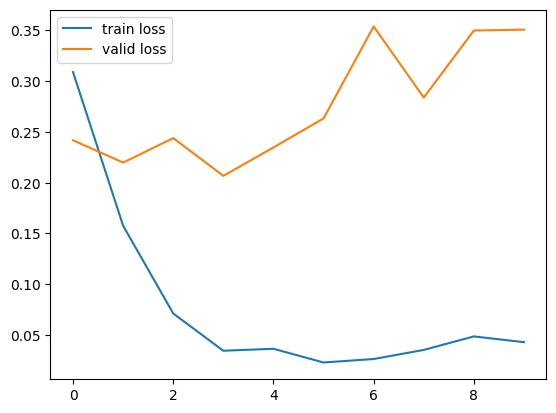

In [47]:
#LOSS PLOT
# Plot the train loss and test loss per iteration
import matplotlib.pyplot as plt 
fig = plt.figure(0)
plt.plot(train_loss_history, label = 'train loss')
plt.plot(valid_loss_history, label = 'valid loss')
plt.legend()

# Log the plot to W&B
wandb.log({"train-test loss per epoch": wandb.Image(plt)})

In [48]:
model_nn = Model(wandb.config.INPUT_DIM, wandb.config.HIDDEN_DIM1, wandb.config.HIDDEN_DIM2, wandb.config.OUTPUT_DIM, non_linearity)
model_nn.to(device)
model_nn.load_state_dict(torch.load(wandb.config.FILE_MODEL))

<All keys matched successfully>

In [49]:
def evaluate_model(data_loader, model, device):
    """ 
    Function to evaluate the performance of a given model on a dataset
    Input: Data iterator, Model, Device (CPU or GPU)
    Output: Predictions, Actual labels, Classification report, F1 score
    """
    # Array to store predicted labels
    predictions = torch.Tensor().to(device)

    # Array to store actual labels
    y_true = torch.Tensor().to(device)

    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        for input_, targets in data_loader:
            input_ = input_.to(device)
            targets = targets.to(device)

            output = model(input_)
            prediction = torch.sigmoid(output)
            indices = (prediction >= 0.5).float()  # Threshold predictions

            # Add the predicted labels to the array
            predictions = torch.cat((predictions, indices))

            # Add the actual labels to the array
            y_true = torch.cat((y_true, targets))

    # Convert tensors to numpy arrays
    predictions = predictions.cpu().numpy()
    y_true = y_true.cpu().numpy()

    # Generate classification report
    report = classification_report(y_true, predictions, target_names=["class1", "class2", ...])

    # Calculate F1 score
    f1 = f1_score(y_true, predictions, average="weighted")

    return predictions, y_true, report, f1

In [50]:
##Function for Accuracy

def get_acc_pred(data_loader, model,device):
    
  """ 
  Function to get predictions and accuracy for a given data using estimated model
  Input: Data iterator, Final estimated weoights, bias
  Output: Precditions and Accuracy for given dataset
  """

  # Array to store predicted labels
  predictions = torch.Tensor() # empty tensor
  predictions = predictions.to(device) # move predictions to GPU

  # Array to store actual labels
  y = torch.Tensor() # empty tensor
  y = y.to(device)

  total=0
  correct=0
  # Iterate over batches from data iterator
  with torch.no_grad():
    for input_, targets in data_loader:
      
      # move inputs and outputs to GPUs
      
      input_ = input_.to(device)
      targets = targets.to(device)
      
      # Calculated the predicted labels
      output = model(input_)

      # Choose the label with maximum probability
      prediction = torch.sigmoid(output)
      indices=prediction
      indices[indices>0.5]=1
      indices[indices<0.5]=0

      # Add the predicted labels to the array
      predictions = torch.cat((predictions, indices)) 

      # Add the actual labels to the array
      y = torch.cat((y, targets))

      predicted = np.round(prediction) #keep in mind that np.round() is a round to even function
      total += targets.size(0)
      #print("Target: ",targets.size(0))
      #print("Predicted: ",predicted)
      #print("Target: ", targets)
      #calculate how many images were correctly classified
      correct += (predicted == targets).sum().item()
      #print(correct)
  accuracy=100.0* (correct/total)
  print("Accuracy: {}%".format(accuracy))
  # Check for complete dataset if actual and predicted labels are same or not
  # Calculate accuracy
  #acc = (predictions == y).float().mean()

  # Return tuple containing predictions and accuracy
  return predictions, y

In [51]:
#Function for predictions
def get_predictions(data_loader, model,device):
    # Array to store predicted labels
    predictions = torch.Tensor() # empty tensor
    predictions = predictions.to(device) # move predictions to GPU

    with torch.no_grad():
        for input_ in data_loader:
        
            # move inputs and outputs to GPUs
        
            input_ = input_.to(device)
            #targets = targets.to(device)
            
            # Calculated the predicted labels
            output = model(input_)

            # Choose the label with maximum probability
            prediction = torch.sigmoid(output)
            indices=prediction
            indices[indices>0.5]=1
            indices[indices<0.5]=0

            # Add the predicted labels to the array
            predictions = torch.cat((predictions, indices)) 
        return predictions
    

In [52]:
print("Weighted F1 score: {:.2f}".format(f1_score(y_true= y_train, y_pred= pred_train, average= 'weighted')))

NameError: name 'pred_train' is not defined

## Predictions

In [53]:
pred_loader=torch.utils.data.DataLoader(X_test_tensor,batch_size=wandb.config.BATCH_SIZE,shuffle=False,num_workers=4)

In [54]:
result=get_predictions(pred_loader,model_nn,device)

In [55]:
result

tensor([[0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 1., 0., 0., 1., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [56]:
y=mlb.inverse_transform(result)

In [57]:
X_test.values

array(['the customer service person was extremely helpful and courteous',
       'monica was awesome   she was friendly and very knowledgeable   she gave my issue her conllete attention and her follow up was thorough',
       'leonel did a great job trying to help me unfortunately he was unable to locate the model of fan i had to purchase replacement parts i understand the ceiling fan is 20 years old but how do you or none of your vendors have information on it when i_x0019_ve provided the model and item number disappointed my issue isn_x0019_t resolved',
       'product was damaged during shipping nsd does not wait to open the box i have been dealing with this since i opened the box the evening it was delivered part can not be replaced so i need to return still waiting on nsd to schedule the pick up for the return i was told 3 5 business days after 6/29 they will contact me then call me the day before via email their contact phone number when you ask to talk to a representative discon

In [58]:
t=pd.DataFrame()
t["pred"]=y
t["comments"]=X_test.values
t["actual_value"]=mlb.inverse_transform(torch.tensor(y_test))

In [59]:
pd.set_option('display.max_colwidth', None)

In [61]:
t.to_csv("IntentSample.csv")